# Vulnerability hatstall

## Introduction

Many companies trend to ignore the importance of cybersecurity whether because they ignore it or they think that it is not important, or at least until they get an attack or their lose their data because of that. Wannacry was the first malware I saw in news because it affected many workstations in a Spanish company. Many people used to ask me about the ransomware and they only focused in the malware but only people who works in cybersecurity, or maybe other curious people, focused in the vulnerability which attackers exploted to infect machines with the ramsonware. 

Many attackers are looking for critical vulnerabilities, especially for those services that are exposed on Internet. The main problem is that patching is not a quick task, especially if you have critical services and your bussiness core is not cybersecurity. That is why we try to make vulnerability management the easiest as we can.

I also realised that it is quite easy to find data science projects in bussiness intelligence but it is very hard to see something about cybersecurity, no only in vulnerability management. 

## Data information

This project has two datasets. 

1. ../PluginsCategorization/Openvas/DatasetInput/OpenvasLookup.json
2. ../PluginsCategorization/Openvas/DatasetInput/ResultsFromScan.csv *(optional)*

The first one was completely created by me based on [Openvas](http://dl.greenbone.net/community-nvt-feed-current.tar.bz2)(aka Greenbone) plugins that can be downloaded for free from its page. I dare to say we are only going to need this one, it is the raw material for this project, if you want to replicate this project you **must have** this dataset.

The second one it is an optional dataset, contains all the results from an Openvas scan, this dataset could be seen as a subgroup from the first one. 

**NOTE**: We have an script that automatically download the data from openvas and created the json file, you can download the code, modify and use it, for the second dataset I download from a Greenbone scan in csv, I ran a scan in a development virtual machine and download the csv file. I want to show something important with this dataset but how I say before, this is completely optional, if you don't download nothing happens. I won't write the steps to reproduce how to download the second dataset because it is not the purpose of this project and I kindly ask you to believe me. When I use it in this document, you will realise why the second dataset it's not as important as the first one. 

### OpenvasLookup.json

This file has the information of the plugins from openvas, many people would think about this as the "universe" of data. This is the information about the fields: 

- oid: It is the unique identifier, must be unique and not null.
- creation_date: Date where the plugin was created.
- last_modification_date: Last date where plugin was modified.
- plugin_name: Name of the openvas plugin, must be unique and not null.
- filename: File where the plugin was parsed. 
- script_category: Category assigned by Openvas.
- script_family: Family assigned by Openvas.
- cve: "Common Vulnerabilities and Exposures" CVE® is a list of entries—each containing an identification number, a description, and at least one public reference—for publicly known cybersecurity vulnerabilities. Information got from [here](https://cve.mitre.org/)
- cvss: "Common Vulnerability Scoring System" The Common Vulnerability Scoring System (CVSS) provides a way to capture the principal characteristics of a vulnerability and produce a numerical score reflecting its severity. Information copied from [here](https://www.first.org/cvss/)
- solution_from_plugin: Contains the solution for the vulnerability. 
- solution_type: Contains the type of solution.
- text: Contains all the raw text, this field could be used to check the extraction from all the fields I mentioned before.

### ResultsFromScan.csv

The fields cve{}, cvss and oid are exactly the same as OpenvasLookup.json. The field "type" it is the same as script_family and "signature" it is exactly as plugin_name. So I am going to explain the other fields. 

- country: It is a tag field, in this case contains the country where the scan was made. 
- IP: Target ip.
- port: target port
- protocol: protocol where the vulnerability was found. 

## Methodology

### A brief explanation about the problem

Before of telling you the methodology I would like to explain how is the proccess.  

1. We run a vulnerability scan.
2. This one return to us results, depends on the scan, infraestructure, and so on, it could be big or small.
3. This scan generate a report and we send that report to their respective patch management.

At the moment, everything it is ok. so, what is it the problem? 

### Problem

Imagine you scan an asset, just one asset, Openvas and many vulnerability tools will give you reports like this: 

- IP: XXX.XXX.XXX.XXX, vuln_id: 1, solution: Upgrade from Firefox **61.0.0** to Firefox **62.0.4**
- IP: XXX.XXX.XXX.XXX, vuln_id: 5,  solution: Upgrade from Firefox **61.0.0** to Firefox **62.0.5**
- IP: XXX.XXX.XXX.XXX, vuln_id: 20,  solution: Upgrade to Firefox **63.0.0**

The first thing you might notice it is that solution does not have a standard. This usually happens in opensource tools like openvas because everybody can build a plugin and upload it for free, even in commertial solutions you can find something like this, other thing to analize is the solution, all of those vulnerabilities can be solve by installing the last version of Mozilla Firefox, or in the worst case just by installing Mozilla Firefox 63.0.0. In this example I am talking about three vulnerabilities but in a real scenario it is much bigger, if anybody sends a report with millions of vulnerabilities to patch area the probabilty of being ignored will become higher.

So, the main **goal** of this project is to propose solutions that can fix as many vulnerabilities as posible, making the vulnerability management easier.  


### Original plan:

![planB](figs/hatstall_openvas.png "Hatstall Openvas Improved")

Those were the steps followed to reach the goal: 

1. Spacy library to do the NLP, It was decided this library instead of nltk because we forgot about lemmatization and tokenization. 
2. Create a function to clean the "text" field in the plugin dataset.
3. Spacy allows to modify few things about tokenization, we used to tokenized CVE's properly. 
4. It was used PhraseMatcher in the text to categorize the solutions. 

#### Advantages: 

- The categorization was more reliable.
- It was easier to explain. 

#### Disadvantages: 

- It is much slower. The categorization problem is not too complex and regular expressions or python strings functions can solve the problem much more efficiently.
- Categorization was the first step but was not the main goal of this project and 90% of the time was spent in categorization.

In conclution this was grateful learning experience but that was not what we expected so it was decided to redesign the project and that what we are going to see in the [next](#Current) section.

### Current: 

![planB](figs/hatstall_openvas_improved2.png "Hatstall Openvas Improved")

Using NLP to categorize all the vulnerabilities works but it is like "killing a fly with a cannon" (Sorry for my bad translation :P), plugins have a category that it is not perfect but they have one, and the process is very slow so it is not worth working on it when regular expressions and python strings methods can do the same work much more efficiently. 

The scope of this project was reached in few days but the satisfaction was close to null so It was decided to think a better way to solve the [problem](#Problem). I was tried many paths and models but it was finally decided any unsupervised ML model, the main goal is to put similar vulnerabilities in the same bag.

So, stop writing rubish and let's start coding.

#### Loading data

First we are going to import all the libraries and define all the functions that we are going to need.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import altair as alt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
#Custom functions were splitted in other scripts to save space in the document
from openvas_data_preprocessing import load_and_clean_dataframe
from openvas_data_preprocessing import preproccess_data
from openvas_data_preprocessing import apply_tfidf_raw_data
from metrics_analysis import get_metrics_dataframe
from metrics_analysis import calculate_metrics_streght
from metrics_analysis import get_values_for_plot
from metrics_analysis import plot_elbow


def plot_samples(x, modelfitted, label="Plugin name vectorized data distribution"):
    """This function is made to plot cluster data.
    Parameters:
    ----------
    x : x axis
    modelfitted: K means model fitted
    label : Label for the plot
    """
    fig = plt.figure(figsize=(10, 10))
    ax_fig = fig.add_subplot(111)
    New_X = x.todense()
    clusters = modelfitted.labels_.tolist()
    pca = PCA(n_components= 2).fit(New_X)
    data2D = pca.transform(New_X)
    ax_fig.scatter(data2D[:,0], data2D[:,1], c=clusters);
    plt.title(label);
    
def put_in_iterator(input_string):
    """Function that put a complete string into tuple
    Parameters:
    ----------
    input_string : Any string to the function
    Returns:
    -------
    the same string into tuple
    """
    my_list = [None]
    return tuple(input_string for s in my_list)

In [2]:
dataset_file = '../PluginsCategorization/Openvas/DatasetInput/OpenvasLookup.json'
openvas_df = pd.read_json(dataset_file)

#### Cleansing and preparation

The cleansing proccess was made in the script "openvas_parser.py", the docstring has relevant information about what the script does. 

The categorization script keeps in mind "informational" plugins but for training model we are going to filter all of them because our project focus on solutions and those plugins are vulnerabilities so they do not have solution. By definition any plugin with cvss = 0 is informational, the field "solution_type" can be used too.

In [3]:
dataset_file = '../PluginsCategorization/Openvas/DatasetInput/OpenvasLookup.json'
openvas_vulns_df = load_and_clean_dataframe(dataset_file, 'json')

After we filtered all the informational vulnerabilities, we are going to do these steps: 

1. Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
2. Remove words that have fewer than 3 characters.
3. Remove all stopwords.
4. Lemmatize words, that means words in third person are changed to first person and verbs in past and future tenses are changed into present.
5. Stemming words, we reduce words to their root form.

In [4]:
openvas_vulns_preprocessed = preproccess_data(openvas_vulns_df,'plugin_name')

[nltk_data] Downloading package stopwords to /home/chucho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/chucho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/chucho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Let's check a sample

In [5]:
openvas_vulns_preprocessed.sample(2)

creation_date                                                cve  \
32002  2015-09-18 15:05:03  [CVE-2015-1789, CVE-2015-1789, CVE-2015-1789, ...   
49006  2019-01-09 15:07:09                                    [CVE-2019-0560]   

       cvss                 cvss_vector                    filename  \
32002   4.3  AV:N/AC:M/Au:N/C:N/I:N/A:P  gb_f5_big_ip_sol16913.nasl   
49006   4.3  AV:N/AC:M/Au:N/C:P/I:N/A:N        gb_ms_kb4461535.nasl   

      last_modification_date     oid  \
32002    2018-10-26 16:03:52  105364   
49006    2019-05-03 08:55:39  814592   

                                             plugin_name  script_category  \
32002  F5 BIG-IP - SOL16913 - OpenSSL vulnerability C...  ACT_GATHER_INFO   
49006  Microsoft Office 2016 Information Disclosure V...  ACT_GATHER_INFO   

                       script_family  \
32002       F5 Local Security Checks   
49006  Windows : Microsoft Bulletins   

                                    solution_from_plugin solution_type  \
32002  See the referenced vendor advisory for a solut...     VendorFix   
49006  The vendor has released updates. Please see th...     VendorFix   

                                                    text    pre_processed  
32002  CPE = "cpe:/h:f5:big-ip";\n\nif (description)\...          openssl  
49006  script_oid("1.3.6.1.4.1.25623.1.0.814592");\n ...  microsoft_offic

#### Analysis

I have been trying different ways to solve this problem but I failed in many of them. The first thing I did but I failed was to clusterized the field "solution_type" but I honestly could not handle the [imbalanced data](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets). Let's analysed the problem a bit more

In [6]:
openvas_solution_type = openvas_vulns_preprocessed[['solution_type','oid']].groupby(
    'solution_type').count().reset_index()

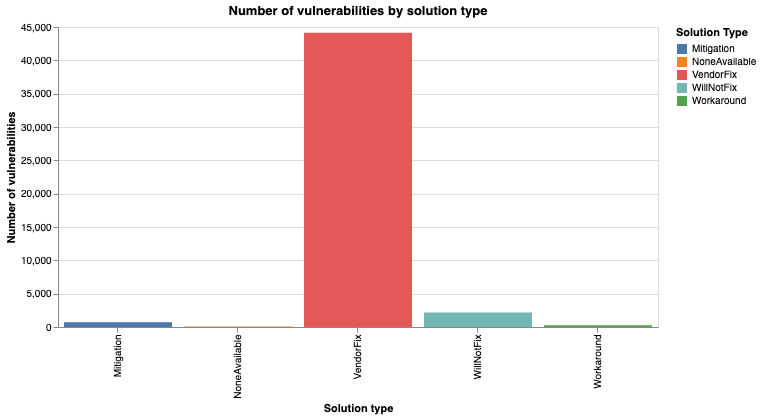

In [7]:
alt.Chart(openvas_solution_type).mark_bar().encode(
    x=alt.X('solution_type', axis=alt.Axis(title='Solution type')),
    y=alt.Y('oid', axis=alt.Axis(title='Number of vulnerabilities')),
    color=alt.Color('solution_type',legend=alt.Legend(title="Solution Type"))
).properties(width=600, title="Number of vulnerabilities by solution type")

As you see, the majory of plugins correspond to the solution type of "vendorfix", in cybersecurity that is the best new anybody can hear because if you get a vulnerability you normally have the patch to solve, it is up to administrator whether apply or not. However if we try to use this field to train any model we are going to have a big problem because the model is going to put all the predictions in the "VendorFix" and that is not what we are looking for.

So, there are three knowns ways to solve unbalanced data problems:

1. Resampling the data
2. Removing samples from the majority class (Undersampling)
3. Adding more examples from the minority class (Oversampling)
4. Combining all I mentioned before.

The first one is not convenient, fortunately this is the nature of the data. Undersampling the dataset by removing data older than 2008 give unexpected results and we also lose a lot of data, and the library [imblearn](https://imbalanced-learn.org/en/stable/index.html) was used to oversample the dataset but We got overfitting problem that It could not solved.

So after walking in many paths without any successful result frustraction showed up:

![Frustration](figs/frustration.jpg "Frustration")

Fortunately there are more fields to explore and the best one to do the clustering is the "plugin_name". Let's check what happens if we look for "Ubuntu".

In [8]:
openvas_vulns_df[openvas_vulns_df["plugin_name"].str.contains("Ubuntu")][['plugin_name']].sample(5)

plugin_name
3928   Ubuntu Update for linux-lts-backport-maverick ...
21673                 Ubuntu Update for linux USN-3016-1
41906                 Ubuntu Update for linux USN-3487-1
31963               Ubuntu Update for firefox USN-2768-1
27298       Ubuntu Update for accountsservice USN-1485-1

If you see many of them are very similar, and there are perfect to put into a cluster. Of course we have to vectorize those plugin name first but we can get a first approach. First we have to check if there are a row with "plugin_name" empty: 

In [9]:
openvas_vulns_df[openvas_vulns_df['plugin_name'].apply(lambda x: x is None)]['oid'].count()

0

Before doing anything, we tried a lot of unsupervised models to solve the problem. We chose the kmeans model because it is easier to explain and it does what we want. So, we are going to use the elbow to get the most optimal K. Let's open the metrics file with the metrics.

**NOTE**: The README File in this github project explain how to get metrics similar to this file,after 2 days of running the script ***openvas_kmeans_elbow_gen.py*** we'd rather to use saved file to show how the most optimal k was decided.

In [10]:
with open('metrics/k_values_metrics_processed.txt', 'r') as f:
    metrics = f.read()
metrics = metrics.split('\n')

In [11]:
metrics_df = get_metrics_dataframe(metrics,2)

Elbow is a visual method to get the most optimal K but in this case we have many elbows and it is not easy to see in the plot, so we decided to used a more analythcal way to get the streght from any elbow and choose the stongesth one. 

**Note**: In the first point of [biblography](#Bibliography) there is the url link where I based to calculate the streght from any elbow.

In [12]:
metrics_df = calculate_metrics_streght(metrics_df)

We are going to use another function to get the values for ploting

In [13]:
x,y,x_max,y_max,x_rel_max,y_rel_max = get_values_for_plot(metrics_df)

And finally we plot the elbow with the annotation of the strongest k. I decided to use the value of 87. We also can use the value of 9 but we don't have 9 clusters for sure, and relative strength dampens the strength of the elbow for large values of k, as these are usually less meaningful but that's not our case. 

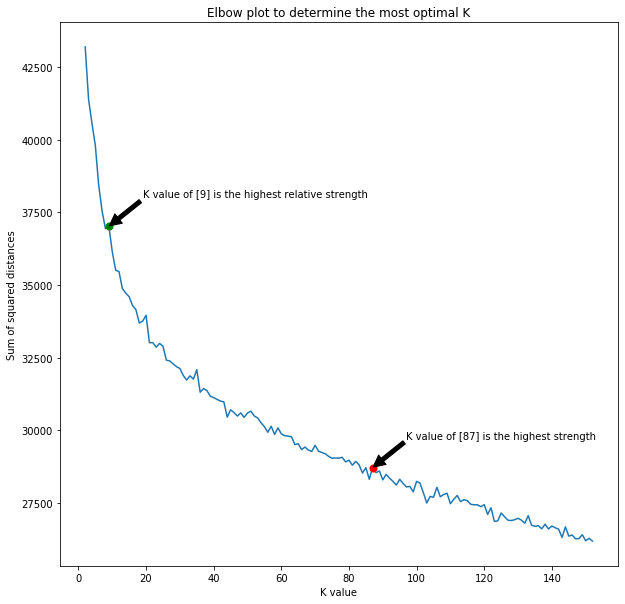

In [14]:
plot_elbow(x,y,x_max,y_max,x_rel_max,y_rel_max)

Now that we ensured the plugin_name field is ok, let's train a model. We apply a tfidf to the "pre-processed" field and we are going to train the model with k value of 87.

In [15]:
tfs,vectorizer = apply_tfidf_raw_data(openvas_vulns_preprocessed, 'pre_processed')

Then I test any kmean model, this is not going to be the final model, we are only going to check if "plugin_name" is suitable to solve our problem.

In [16]:
true_k = 87
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(tfs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=87, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Let's check how our data looks like before testing the results.

**NOTE:** I did not find a more efficient way to plot this. It spends quite long to plot

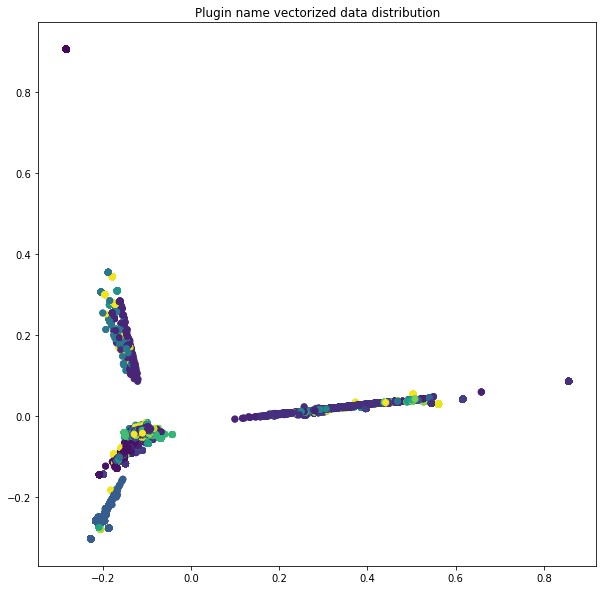

In [17]:
plot_samples(tfs,model)

Now we trained the model, we are going to apply it in our dataframe. Basically we are going to follow these steps:

1. Convert plugin_name strings to iteractors with the function "put_in_iterator".
2. Vectorize all plugins name.
3. Predict the cluster number.
4. Get the number cluster.

Let's do it:

In [18]:
openvas_vulns_preprocessed['cluster_label'] = openvas_vulns_preprocessed['pre_processed']\
                                              .apply(put_in_iterator)
openvas_vulns_preprocessed['cluster_label'] = openvas_vulns_preprocessed.cluster_label\
                                              .apply(vectorizer.transform)
openvas_vulns_preprocessed['cluster_label'] = openvas_vulns_preprocessed.cluster_label\
                                              .apply(model.predict)
openvas_vulns_preprocessed['cluster_label'] = openvas_vulns_preprocessed.cluster_label\
                                              .apply(lambda x: x[0])

Let's play with our data, for example, what happens if I look for "Firefox"?

In [19]:
openvas_vulns_preprocessed[openvas_vulns_preprocessed["plugin_name"]
                 .str.contains("Firefox")][['plugin_name','cluster_label']].sample(5)

plugin_name  cluster_label
33752  Mozilla Firefox Plugin Initialization Use-afte...              9
29835  Mozilla Firefox ESR SVG Privilege Escalation V...             29
16736  Mozilla Firefox ESR Integer Overflow Vulnerabi...             29
13044  Mozilla Firefox JavaScript Compiler Code Execu...             29
40041  Mozilla Firefox ESR Security Updates(mfsa_2017...             50

In [20]:
openvas_plugins_groupped = openvas_vulns_preprocessed[openvas_vulns_preprocessed["plugin_name"]
                                            .str.contains("Firefox")]\
                            .groupby('cluster_label').count().reset_index()

firefox_plugins = openvas_plugins_groupped[['cluster_label','oid']]\
                        .append(openvas_plugins_groupped[['oid']]\
                        .sum(numeric_only=True), ignore_index=True)

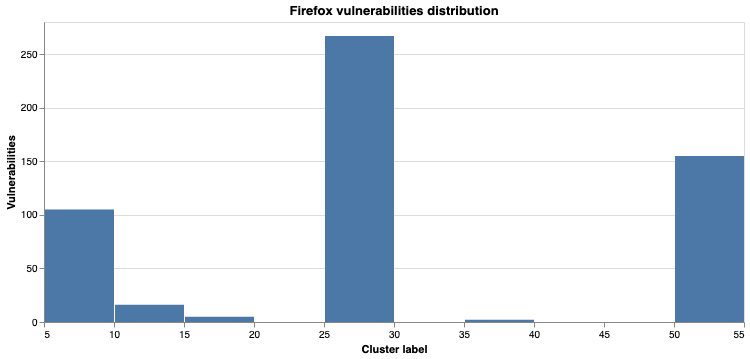

In [21]:
histogram = alt.Chart(firefox_plugins).mark_bar().encode(
    x=alt.X('cluster_label', axis=alt.Axis(title='Cluster label'), bin=True),
    y=alt.Y('oid', axis=alt.Axis(title='Vulnerabilities'))
).properties(width=700, title="Firefox vulnerabilities distribution")

histogram

The model looks like good, you can see how Firefox vulnerabilities are concentrated, but unfortunately this model is not good as we can. Let's check why.  

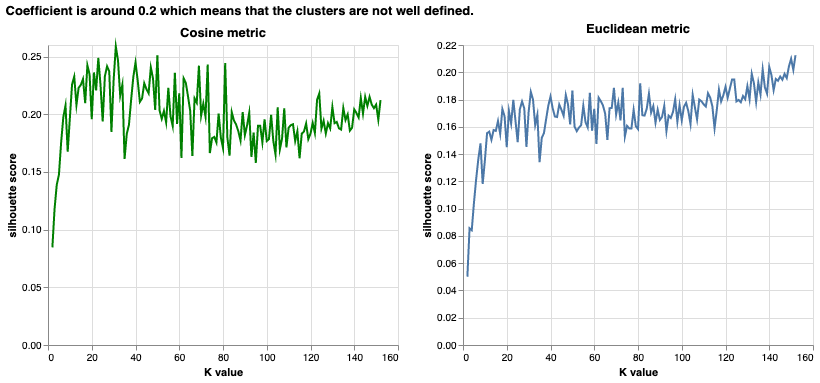

In [22]:
sil_cosine = alt.Chart(metrics_df).mark_line().encode(
    x=alt.X('k_value', axis=alt.Axis(title='K value')),
    y=alt.Y('sil_coef_cos', axis=alt.Axis(title='silhouette score')),
    color=alt.value("green")
).properties(width=350, title="Cosine metric")

sil_euclidean = alt.Chart(metrics_df).mark_line().encode(
    x=alt.X('k_value', axis=alt.Axis(title='K value')),
    y=alt.Y('sil_coef_euc', axis=alt.Axis(title='silhouette score')),
).properties(width=350, title="Euclidean metric")

alt.hconcat(sil_cosine,
            sil_euclidean)\
.properties(title="Coefficient is around 0.2 which means that the clusters are not well defined.")


This does not seen to be reliable but without pre-processing data this metric was around 0 which means there is overlapping between clusters, this metrics are not the best but for sure is an improvement. 

#### Bonus

Do you remember in data section another dataset with the [results](#ResultsFromScan.csv) from openvas scanner?

Well, we have been working with plugins basically because plugins can be considered as the universe and results is a subconjunt of plugins. That is mean if we have a good clustering for plugins, we will have a very good cluster for results. Let's check about it.

In [23]:
result_file = '../PluginsCategorization/Openvas/DatasetInput/ResultsFromScan.csv'
openvas_result_df = load_and_clean_dataframe(result_file, 'csv')
openvas_result_preprocessed = preproccess_data(openvas_result_df,'signature')

[nltk_data] Downloading package stopwords to /home/chucho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/chucho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/chucho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We want to get cluster label and we have got two options:

1. Join with the plugins dataset
2. Use our model to predict the cluster_label

We applied the second option, let's work on it

In [24]:
openvas_result_preprocessed['cluster_label'] = openvas_result_preprocessed['pre_processed']\
                                              .apply(put_in_iterator)
openvas_result_preprocessed['cluster_label'] = openvas_result_preprocessed.cluster_label\
                                              .apply(vectorizer.transform)
openvas_result_preprocessed['cluster_label'] = openvas_result_preprocessed.cluster_label\
                                              .apply(model.predict)
openvas_result_preprocessed['cluster_label'] = openvas_result_preprocessed.cluster_label\
                                              .apply(lambda x: x[0])

Let's do the same steps with results and plot the distribution with "Firefox" word.

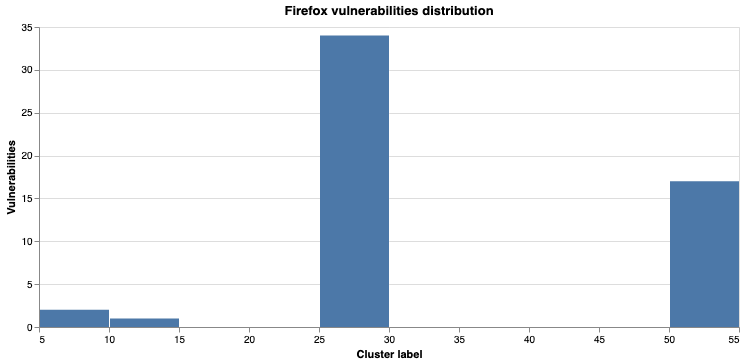

In [25]:
openvas_results_groupped = openvas_result_preprocessed[openvas_result_preprocessed["signature"]
                                            .str.contains("Firefox")]\
                            .groupby('cluster_label').count().reset_index()

firefox_results = openvas_results_groupped[['cluster_label','oid']]\
                        .append(openvas_results_groupped[['oid']]\
                        .sum(numeric_only=True), ignore_index=True)

histogram_results = alt.Chart(firefox_results).mark_bar().encode(
    x=alt.X('cluster_label', axis=alt.Axis(title='Cluster label'), bin=True),
    y=alt.Y('oid', axis=alt.Axis(title='Vulnerabilities'))
).properties(width=700, title="Firefox vulnerabilities distribution")

histogram_results

Data distribution was similar to plugins, of course there are outliers but this seems quite good.
So, let's save plugins and results dataframe into a csv file and to index in [Splunk](www.splunk.com). 

Splunk is the tool decided to visualize the work into an interactive environment. Hope you enjoy it. 

In [26]:
output_result_file = '../PluginsCategorization/Openvas/DatasetOutput/ResultsLabeled.csv'
output_plugins_file = '../PluginsCategorization/Openvas/DatasetOutput/PluginsLabeled.csv'
openvas_result_preprocessed.to_csv(output_result_file, index=False)
openvas_vulns_preprocessed.to_csv(output_plugins_file, index=False)

## Dashboard 

The dashboard was created in Splunk, despite is a proprietary software Splunk is the best for these use cases, especially for its ease of creating dashboards with just SPL(Search Proccesing Language) and XML file.

### Inputs

- Textbox: It is there to search any signature(or plugin_name), you can specify a signature but it is recommended to use wildcards instead, for example \*firefox\*. By default the textbox search for all signatures.
    
    ![Dashboard](figs/textbox.png "Splunk Dashboard")

- Checkbox: It is there to choose severity of vulnerabilities, you can choose one or all of them, by default is chose the "Critical" severities because administrators normally will patch the most critical one. 

    ![Dashboard](figs/checkbox.png "Splunk Dashboard")

### Outputs

#### Single values

- The left single value contains all the vulnerabilities without aggregating, that is a normal report. and the right one have the value of aggregated vulnerabilities, that's the new report. In the picture below we have 312 Critical vulnerabilities and in the right we have 10. That's mean that we reduced the patching report from 312 to 10, because apply 10 solutions is will solve the 312 vulnerabilities. The values have **drilldown** so if you click you will see the detail.

    ![Dashboard](figs/single_values.png "Splunk Dashboard")
    
#### Treemap

- This is the graphical way to check clustering is working good, click on any of those maps and you will see all the vulnerabilities that are similar and can be solved by just applying one patch.

    ![Dashboard](figs/treemap.png "Splunk Dashboard")

## Conclusion

This model is far from being perfect, sure, but this is a real case when we started from scratch, created a custom dataset and processed in many ways. The model could be improved for sure, but the key of that improvement is the pre-processing of data.

This project is more an personal dream that a simple project so we are going to improve this solution and this metrics but we have not been as close as we are now. This model help us to make vulnerability management easier. 

## Bibliography

To choose the machine learning model: 

- https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

To pre-process data:
- https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html#topic=0&lambda=1&term=

To determine the number of clusters:
- https://www.datasciencecentral.com/profiles/blogs/how-to-automatically-determine-the-number-of-clusters-in-your-dat

- https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

Another ideas were got from here:

- https://shichaoji.com/2017/02/18/unsupervised-learning-2-dimension-reduction-pca-tf-idf-sparse-matrix-twitter-posts-clustering/

- https://towardsdatascience.com/2-latent-methods-for-dimension-reduction-and-topic-modeling-20ff6d7d547?gi=74b52138eab2

